In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
from owi_data_2_pandas.io import API
import datetime
from pytz import utc
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Import vub Meetenet Vlaamse Banken API functions
from vubmvbc.config import Credentials
from vubmvbc.client import Base
from vubmvbc.objects import Catalog, Data
import vubmvbc.data_getter as dg

from oma_tracking.oma_clustering import ModeClusterer  #pip install hdbscan --no-build-isolation --no-binary :all
from oma_tracking.data.make_dataset import DatasetGetter
from oma_tracking.data.utils import get_rated_data, get_parked_data

In [61]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2d01'
data_path = "../../data/nw2/raw/nw2d01_" + start.strftime("%Y%m%d") + "_" + stop.strftime("%Y%m%d") + ".parquet"

save = False
load = True

if save:
    dsg = DatasetGetter(start, stop, location)
    dsg.get_longterm_data()
    dsg.save_data(data_path)

if load:
    data = pd.read_parquet(data_path)

Python-dotenv could not parse statement starting at line 2


In [63]:
rated_data = get_rated_data(data)
parked_data = get_parked_data(data)

In [18]:
mpe_data = data.filter(regex='mpe')
mpe_FA = \
    pd.DataFrame.from_records(
        mpe_data['_'.join(['mpe', name_location, 'FA'])].explode().dropna().tolist()
    )\
        .set_index(
            mpe_data['_'.join(['mpe', name_location, 'FA'])].explode().dropna().index
        )
mpe_SS = \
    pd.DataFrame.from_records(
        mpe_data['_'.join(['mpe', name_location, 'SS'])].explode().dropna().tolist()
    )\
        .set_index(
            mpe_data['_'.join(['mpe', name_location, 'SS'])].explode().dropna().index
        )

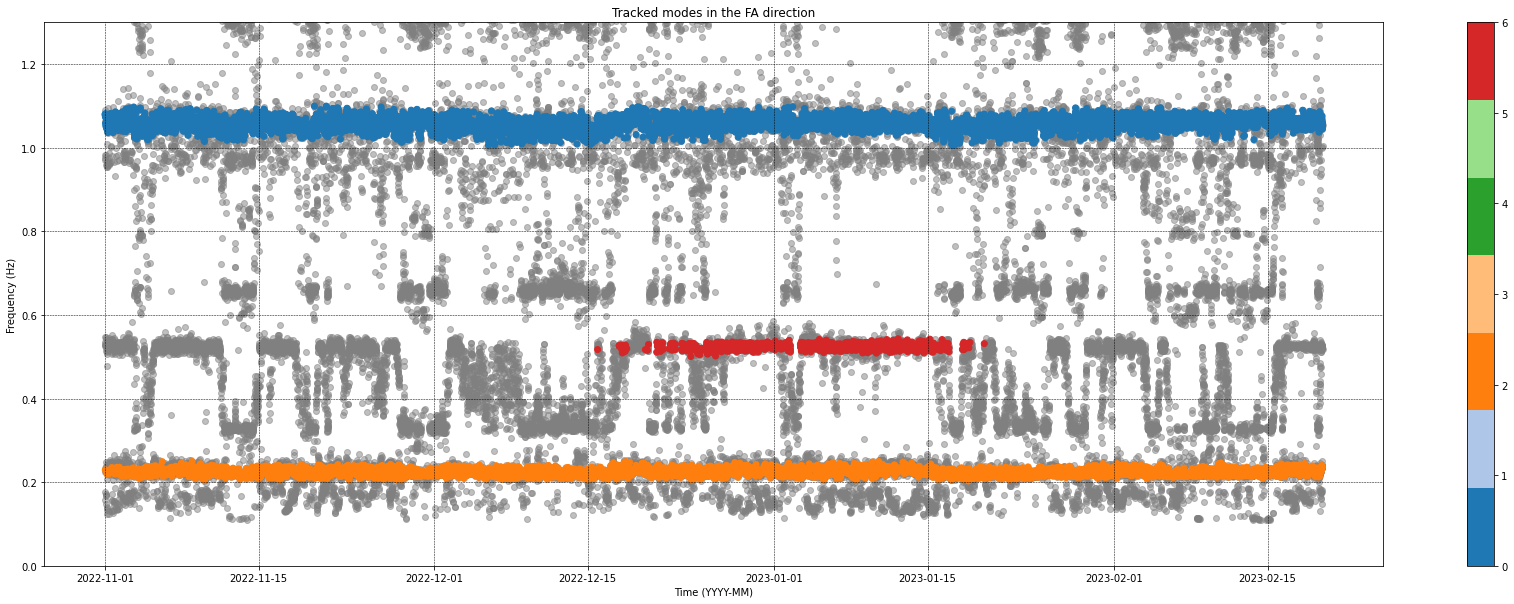

In [19]:
mc = ModeClusterer(
    eps = 5,
    min_samples = 15,
    multipliers = {"frequency": 500, "size": 2, "damping": 2},
    index_divider = 1200,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

culstering_data = mpe_FA.rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc.fit(culstering_data)
clustered_modes = mc.predict(min_cluster_size=1000)

fig = plt.figure(figsize = (30,10))
plt.scatter(culstering_data.index, culstering_data['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes.labels.unique()),1))
cmap = ListedColormap(first_colors)

plt.scatter(clustered_modes.index, clustered_modes['frequency'], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar()
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the FA direction')
plt.ylim(0, 1.3)
plt.show()
FA1 = clustered_modes[clustered_modes.labels == 2]
FA2 = clustered_modes[clustered_modes.labels == 0]

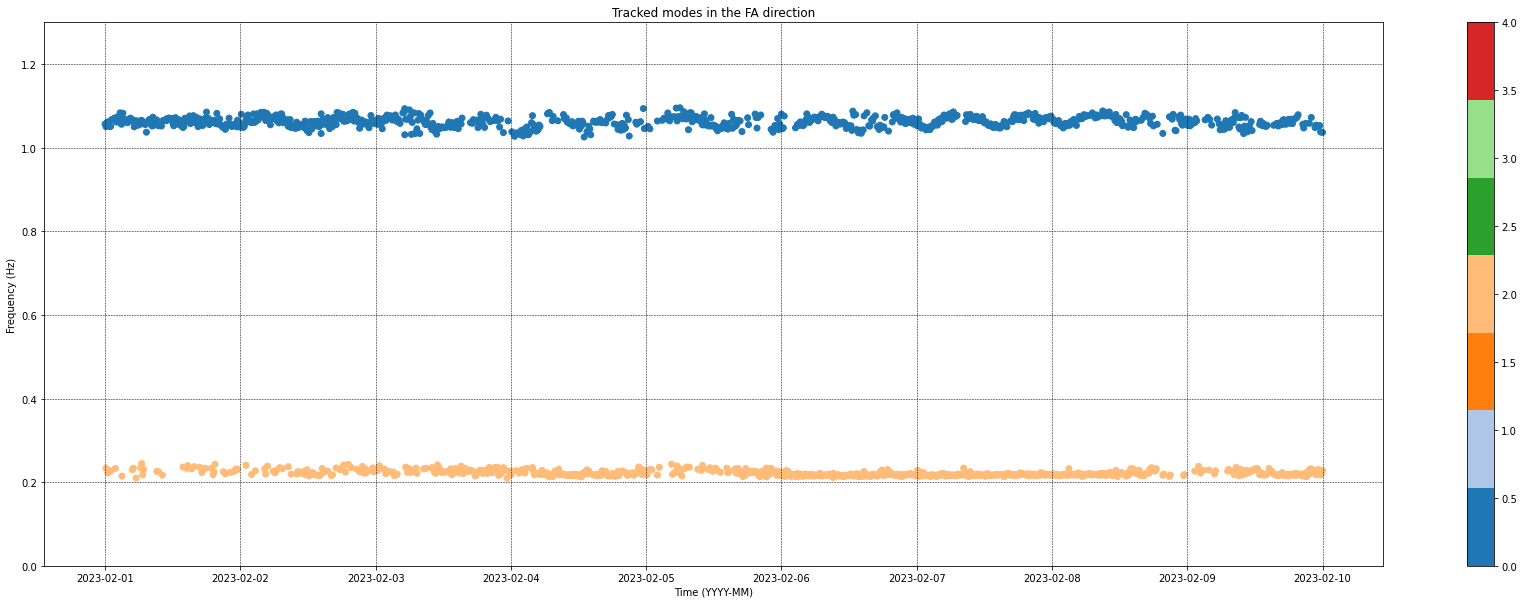

In [20]:
start = datetime.datetime(2023,2,1,tzinfo=utc)
end = datetime.datetime(2023,2,10,tzinfo=utc)
fig = plt.figure(figsize = (30,10))

plt.scatter(clustered_modes.loc[start:end].index, clustered_modes.loc[start:end]['frequency'], c=clustered_modes.loc[start:end]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar()
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the FA direction')
plt.ylim(0, 1.3)
plt.show()

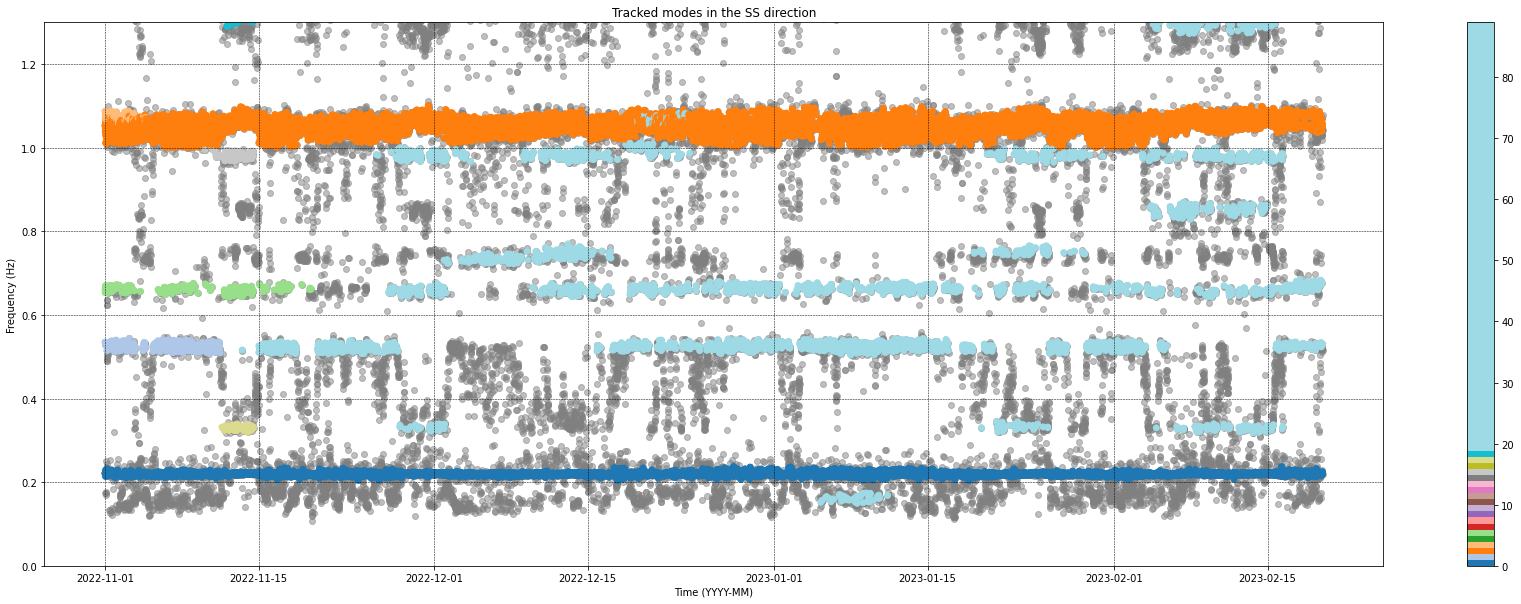

In [21]:
mc = ModeClusterer(
    eps = 4,
    min_samples = 15,
    multipliers = {"frequency": 500, "size": 1, "damping": 1},
    index_divider = 1000,
    cols = ["frequency", "size", "damping"],
    min_size = 10,
    max_damping = 10,)

culstering_data = mpe_SS.rename(columns={'mean_frequency':'frequency', 'mean_damping':'damping', 'size':'size'})
mc.fit(culstering_data)
clustered_modes = mc.predict(min_cluster_size=50)

fig = plt.figure(figsize = (30,10))
plt.scatter(culstering_data.index, culstering_data['frequency'], alpha=0.5, color='grey')

tab10 = plt.get_cmap('tab20')
first_colors = tab10(range(0,len(clustered_modes.labels.unique()),1))
cmap = ListedColormap(first_colors)

plt.scatter(clustered_modes.index, clustered_modes['frequency'], c=clustered_modes['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)
cbar = plt.colorbar()
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the SS direction')
plt.ylim(0, 1.3)
plt.show()
SS1 = clustered_modes[clustered_modes.labels == 0]
SS2 = clustered_modes[clustered_modes.labels == 2]

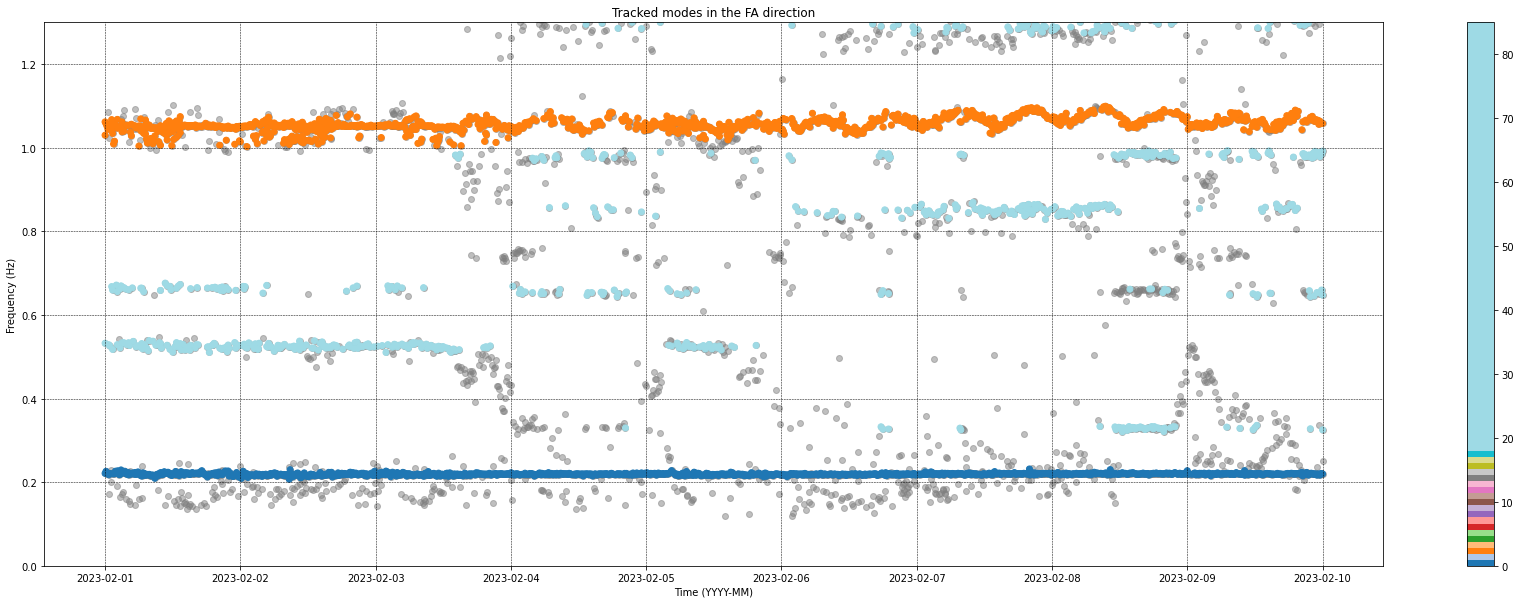

In [22]:
start = datetime.datetime(2023,2,1,tzinfo=utc)
end = datetime.datetime(2023,2,10,tzinfo=utc)
fig = plt.figure(figsize = (30,10))

plt.scatter(culstering_data.loc[start:end].index, culstering_data.loc[start:end]['frequency'], alpha=0.5, color='grey')

plt.scatter(clustered_modes.loc[start:end].index, clustered_modes.loc[start:end]['frequency'], c=clustered_modes.loc[start:end]['labels'], cmap = cmap)
plt.grid(True, color='k', linestyle='--', linewidth=0.5)

cbar = plt.colorbar()
plt.xlabel('Time (YYYY-MM)')
plt.ylabel('Frequency (Hz)')
plt.title('Tracked modes in the FA direction')
plt.ylim(0, 1.3)
plt.show()

In [23]:
def read_csv_files(folder_path):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    dfs = {}
    for file in csv_files:
        filename = file.split('.csv')[0]
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath)
        dfs[filename] = df
    return dfs

In [24]:
simulations_data_path = "../../data/nw2/simulations/" + location + "/"
simulation_data = read_csv_files(simulations_data_path)

In [25]:
simulation_data.keys()

dict_keys(['Eigen_parked', 'Eigen_parked_LS_0.1D', 'Eigen_parked_LS_0.2D', 'Eigen_parked_LS_0.3D', 'Eigen_parked_LS_0.4D', 'Eigen_parked_LS_0.5D', 'Eigen_parked_LS_0.6D', 'Eigen_parked_LS_0.7D', 'Eigen_parked_LS_0.8D', 'Eigen_parked_scour_1', 'Eigen_parked_scour_2', 'Eigen_rated', 'Eigen_rated_LS_0.1D', 'Eigen_rated_LS_0.2D', 'Eigen_rated_LS_0.3D', 'Eigen_rated_LS_0.4D', 'Eigen_rated_LS_0.5D', 'Eigen_rated_LS_0.6D', 'Eigen_rated_LS_0.7D', 'Eigen_rated_LS_0.8D', 'Eigen_rated_scour_1', 'Eigen_rated_scour_2', 'Errors_No_scour'])

In [26]:
tracked_modes = \
        {
            '1st FA': FA1,
            '2nd FA': FA2,
            '1st SS': SS1,
            '2nd SS': SS2
        }

In [27]:
def draw_modal_frequency_boxplots(simulation_data, location, mode):
    fig, ax = plt.subplots(figsize=(20, 5))
    i = 1
    x_keys = []
    plt.boxplot(tracked_modes[mode].frequency, positions=[i], widths=0.6)
    x_keys.append('tracked mode')
    i += 1
    plt.boxplot(tracked_modes[mode].loc[tracked_modes[mode].index.intersection(parked_data.index)].frequency, positions=[i], widths=0.6)
    x_keys.append('tracked mode parked')
    i += 1
    plt.boxplot(tracked_modes[mode].loc[tracked_modes[mode].index.intersection(rated_data.index)].frequency, positions=[i], widths=0.6)
    x_keys.append('tracked mode rated')
    i += 1
    for key in simulation_data.keys():
        if mode in simulation_data[key].columns:
            plt.boxplot(simulation_data[key][mode], positions=[i], widths=0.6)
            i += 1
            x_keys.append(key)
    
    ax.set_xticks(range(1, len(x_keys) + 1))
    ax.set_xticklabels(x_keys, rotation=90)
    ax.set_title(location + ' ' + mode)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Simulation')
    ax.grid(True, color='k', linestyle='--', linewidth=0.5)
    plt.show()

def draw_modal_frequency_violinplots(simulation_data, location, mode):
    fig, ax = plt.subplots(figsize=(20, 5))
    i = 1
    x_keys = []
    plt.violinplot(tracked_modes[mode].frequency, positions=[i], widths=0.6)
    x_keys.append('tracked mode')
    i += 1
    plt.violinplot(tracked_modes[mode].loc[tracked_modes[mode].index.intersection(parked_data.index)].frequency, positions=[i], widths=0.6)
    x_keys.append('tracked mode parked')
    i += 1
    plt.violinplot(tracked_modes[mode].loc[tracked_modes[mode].index.intersection(rated_data.index)].frequency, positions=[i], widths=0.6)
    x_keys.append('tracked mode rated')
    i += 1
    for key in simulation_data.keys():
        if mode in simulation_data[key].columns:
            plt.violinplot(simulation_data[key][mode], positions=[i], widths=0.6)
            i += 1
            x_keys.append(key)
    
    ax.set_xticks(range(1, len(x_keys) + 1))
    ax.set_xticklabels(x_keys, rotation=90)
    ax.set_title(location + ' ' + mode)
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Simulation')
    ax.grid(True, color='k', linestyle='--', linewidth=0.5)
    plt.show()

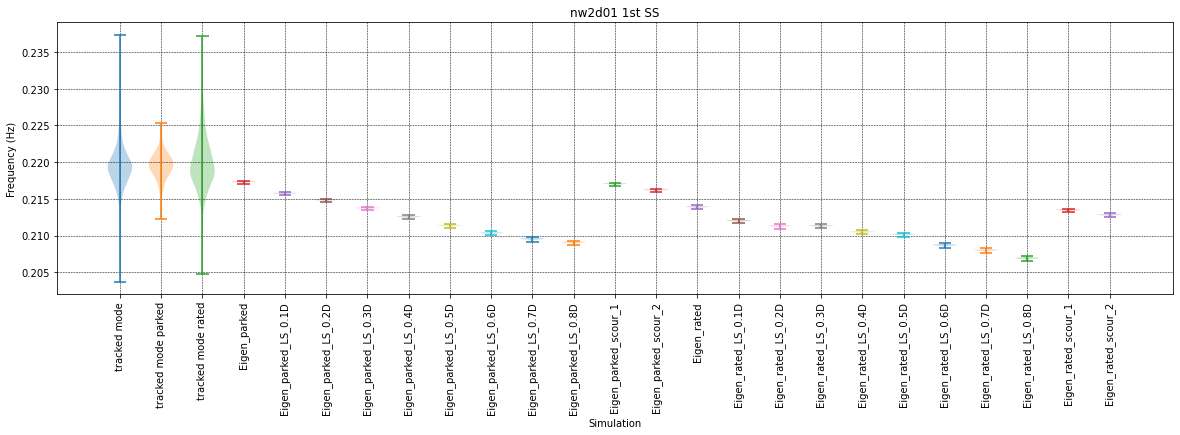

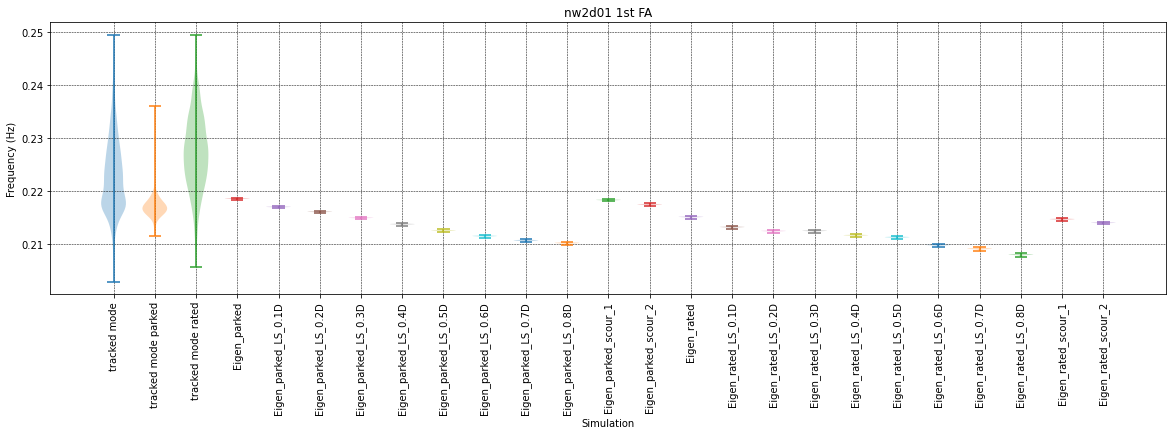

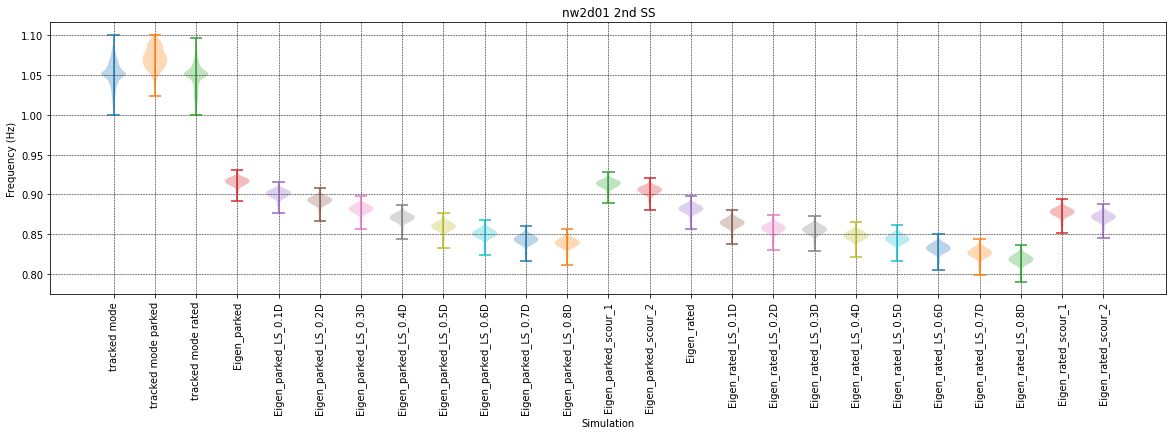

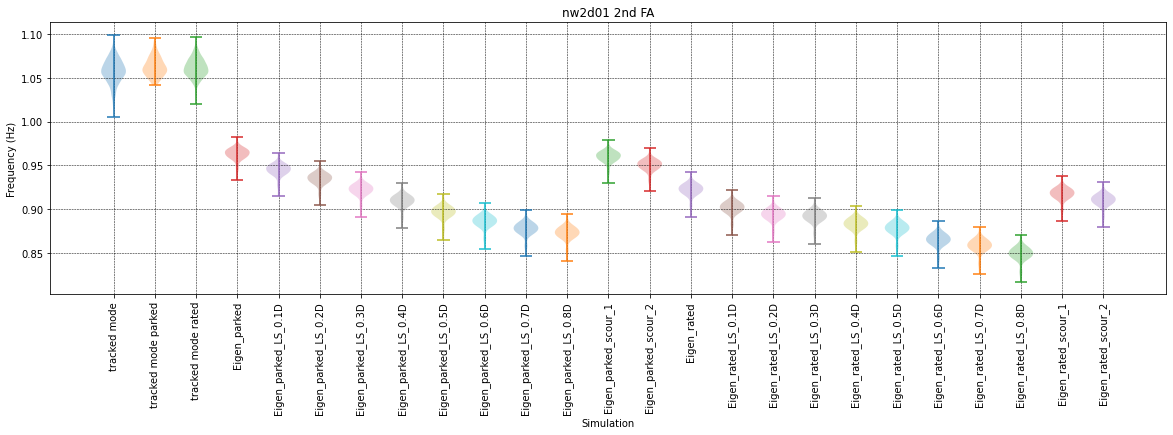

In [28]:
draw_modal_frequency_violinplots(simulation_data, location, '1st SS')
draw_modal_frequency_violinplots(simulation_data, location, '1st FA')
draw_modal_frequency_violinplots(simulation_data, location, '2nd SS')
draw_modal_frequency_violinplots(simulation_data, location, '2nd FA')

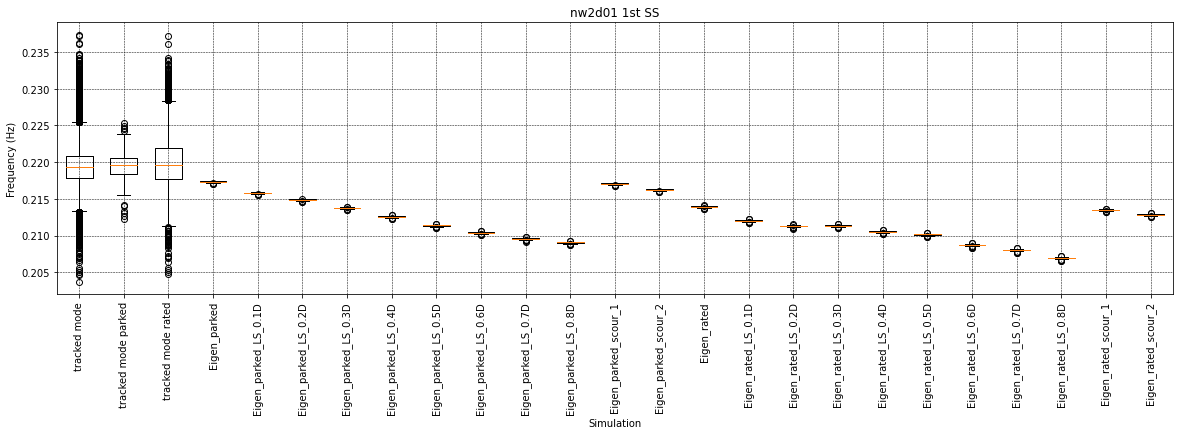

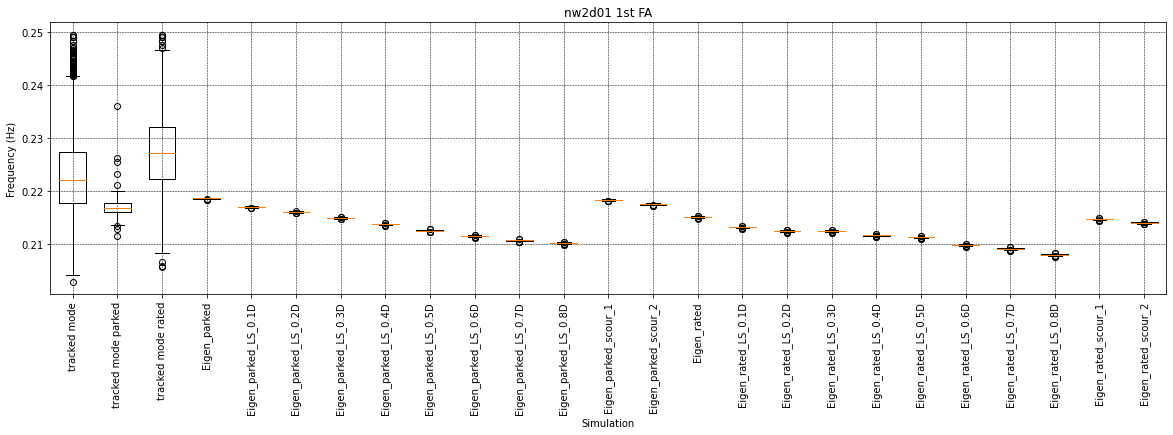

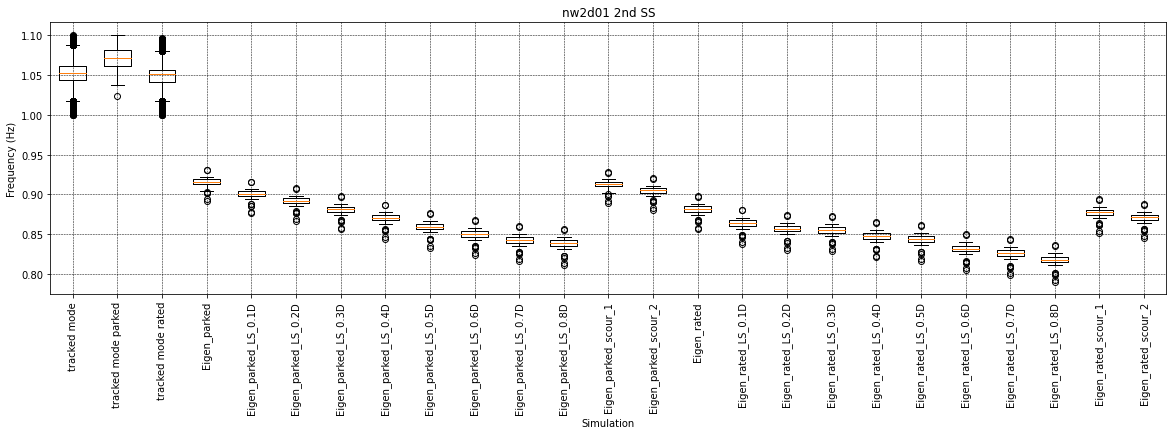

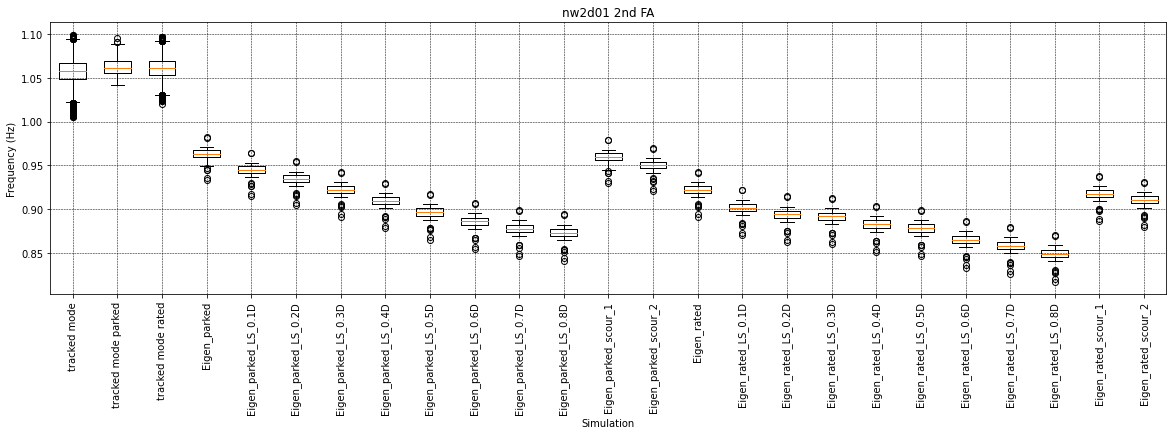

In [29]:
draw_modal_frequency_boxplots(simulation_data, location, '1st SS')
draw_modal_frequency_boxplots(simulation_data, location, '1st FA')
draw_modal_frequency_boxplots(simulation_data, location, '2nd SS')
draw_modal_frequency_boxplots(simulation_data, location, '2nd FA')

In [30]:
simulation_data.keys()

dict_keys(['Eigen_parked', 'Eigen_parked_LS_0.1D', 'Eigen_parked_LS_0.2D', 'Eigen_parked_LS_0.3D', 'Eigen_parked_LS_0.4D', 'Eigen_parked_LS_0.5D', 'Eigen_parked_LS_0.6D', 'Eigen_parked_LS_0.7D', 'Eigen_parked_LS_0.8D', 'Eigen_parked_scour_1', 'Eigen_parked_scour_2', 'Eigen_rated', 'Eigen_rated_LS_0.1D', 'Eigen_rated_LS_0.2D', 'Eigen_rated_LS_0.3D', 'Eigen_rated_LS_0.4D', 'Eigen_rated_LS_0.5D', 'Eigen_rated_LS_0.6D', 'Eigen_rated_LS_0.7D', 'Eigen_rated_LS_0.8D', 'Eigen_rated_scour_1', 'Eigen_rated_scour_2', 'Errors_No_scour'])

In [31]:
simulation_data['Eigen_parked'].mean()

C:\Users\Max\AppData\Local\Temp\ipykernel_30732\1149896210.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  simulation_data['Eigen_parked'].mean()


1st SS        0.217316
1st FA        0.218541
2nd SS        0.915194
2nd FA        0.962389
SWL [mLAT]    2.685661
dtype: float64

In [32]:
simulation_data['Eigen_parked_LS_0.1D'].mean()

C:\Users\Max\AppData\Local\Temp\ipykernel_30732\583465475.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  simulation_data['Eigen_parked_LS_0.1D'].mean()


1st SS        0.215756
1st FA        0.216950
2nd SS        0.899921
2nd FA        0.944078
SWL [mLAT]    2.685661
dtype: float64

In [33]:
def get_average_diff(simulation_data, operational_condition:str = 'parked'):
    average_diff = {}
    for key in simulation_data.keys():
        if operational_condition in key:
            if len(key.split('_')) == 2:
                ref = simulation_data[key].mean()
                #average_diff[operational_condition] = ref
            elif len(key.split('_')) > 2:
                average_diff[key] = (ref - simulation_data[key].mean())/ref
    return average_diff

In [34]:
average_diff = get_average_diff(simulation_data, 'parked')
average_diff.keys()

C:\Users\Max\AppData\Local\Temp\ipykernel_30732\2576983484.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ref = simulation_data[key].mean()
C:\Users\Max\AppData\Local\Temp\ipykernel_30732\2576983484.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_diff[key] = (ref - simulation_data[key].mean())/ref


dict_keys(['Eigen_parked_LS_0.1D', 'Eigen_parked_LS_0.2D', 'Eigen_parked_LS_0.3D', 'Eigen_parked_LS_0.4D', 'Eigen_parked_LS_0.5D', 'Eigen_parked_LS_0.6D', 'Eigen_parked_LS_0.7D', 'Eigen_parked_LS_0.8D', 'Eigen_parked_scour_1', 'Eigen_parked_scour_2'])

In [35]:
FA1.frequency - average_diff[key][mode]*FA1.frequency.mean()/100

NameError: name 'key' is not defined

0.007281350765601339
0.011481155019172169
0.016710360333631855
0.022209422479506854
0.027730550792944317
0.03245272735535447
0.03624651407498156
0.03843226122572757
0.0012942963026007718
0.0051212735919087034


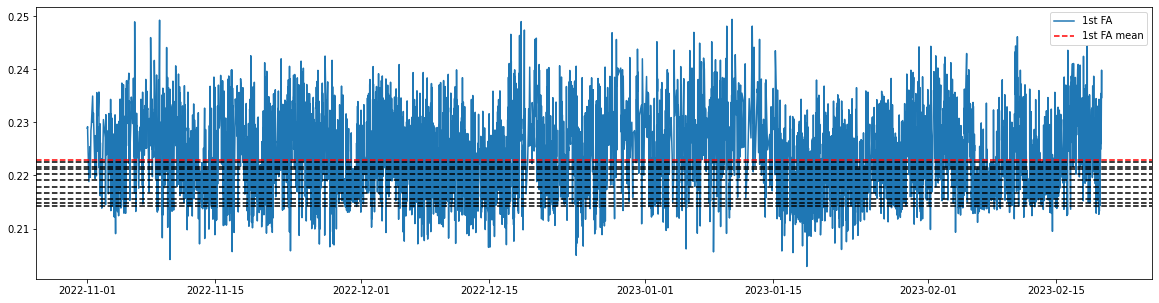

In [ ]:
mode = '1st FA'
plt.figure(figsize=(20, 5))
plt.plot(FA1.frequency, label=mode)
plt.axhline(FA1.frequency.mean(), color='red', linestyle= '--', label=mode + ' mean')
for key in average_diff.keys():
    print(average_diff[key][mode])
    plt.axhline(FA1.frequency.mean() - average_diff[key][mode] * FA1.frequency.mean(), color='k', linestyle= '--')
plt.legend()
plt.show()

0.007181500271053937
0.011324912150918567
0.01648496119717332
0.02191265339144397
0.02736347860980863
0.03202666135929404
0.0357737273449189
0.037932848552005675
0.0012762979501704961
0.0050507037188709525


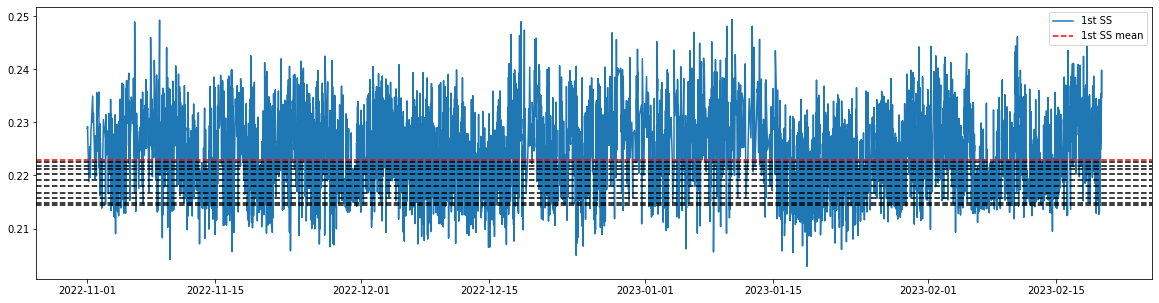

In [ ]:
mode = '1st SS'
plt.figure(figsize=(20, 5))
plt.plot(SS1.frequency, label=mode)
plt.axhline(SS1.frequency.mean(), color='red', linestyle= '--', label=mode + ' mean')
for key in average_diff.keys():
    print(average_diff[key][mode])
    plt.axhline(SS1.frequency.mean() - average_diff[key][mode] * SS1.frequency.mean(), color='k', linestyle= '--')
plt.legend()
plt.show()

0.019026090862510562
0.029688832987578184
0.042758415431704846
0.05620969973327531
0.06941864625790249
0.08045134187834783
0.08919449364611641
0.09418428676254255
0.0034898555705764034
0.013513089683668178


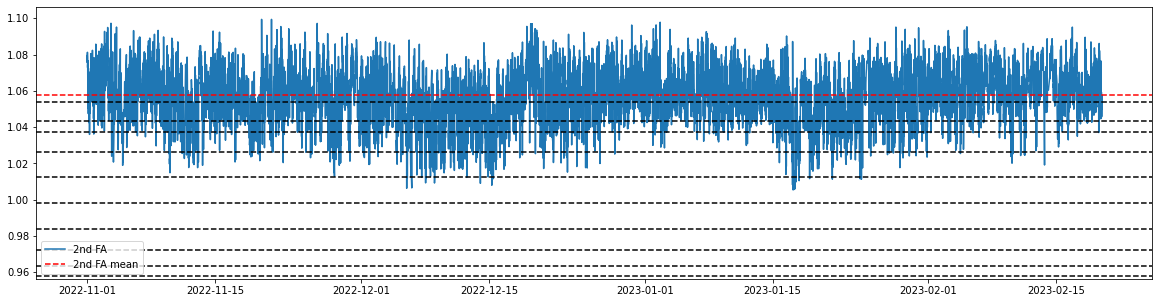

In [ ]:
mode = '2nd FA'
plt.figure(figsize=(20, 5))
plt.plot(FA2.frequency, label=mode)
plt.axhline(FA2.frequency.mean(), color='red', linestyle= '--', label=mode + ' mean')
for key in average_diff.keys():
    print(average_diff[key][mode])
    plt.axhline(FA2.frequency.mean() - average_diff[key][mode] * FA2.frequency.mean(), color='k', linestyle= '--')
plt.legend()
plt.show()

0.016688203924103116
0.02613455031417662
0.03779614489350923
0.04988922305715026
0.061851178229888344
0.07190563647458335
0.07991156972597556
0.08449445908273537
0.0030412112330808405
0.011827191615880356


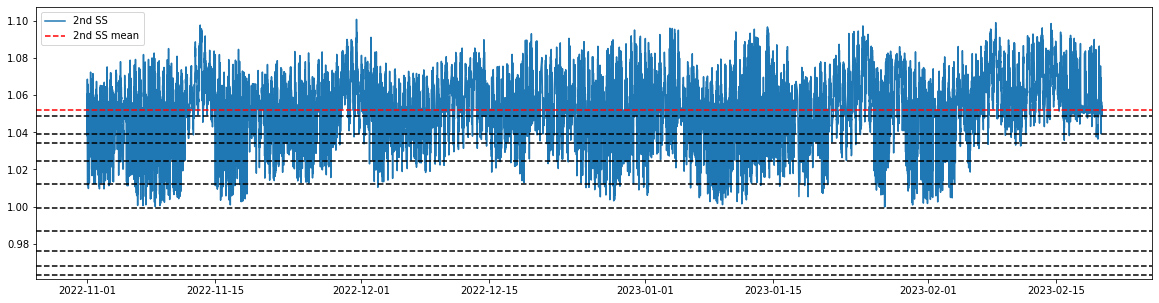

In [ ]:
mode = '2nd SS'
plt.figure(figsize=(20, 5))
plt.plot(SS2.frequency, label=mode)
plt.axhline(SS2.frequency.mean(), color='red', linestyle= '--', label=mode + ' mean')
for key in average_diff.keys():
    print(average_diff[key][mode])
    plt.axhline(SS2.frequency.mean() - average_diff[key][mode] * SS2.frequency.mean(), color='k', linestyle= '--')
plt.legend()
plt.show()

In [ ]:
tracked_modes[mode].loc[tracked_modes[mode].index.intersection(parked_data.index)].frequency.mean()

1.071317029897405

In [ ]:
average_diff.keys()

dict_keys(['Eigen_parked_LS_0.1D', 'Eigen_parked_LS_0.2D', 'Eigen_parked_LS_0.3D', 'Eigen_parked_LS_0.4D', 'Eigen_parked_LS_0.5D', 'Eigen_parked_LS_0.6D', 'Eigen_parked_LS_0.7D', 'Eigen_parked_LS_0.8D', 'Eigen_parked_scour_1', 'Eigen_parked_scour_2'])

In [ ]:
average_diff_parked

{'Eigen_parked_LS_0.1D': 1st SS        0.007182
 1st FA        0.007281
 2nd SS        0.016688
 2nd FA        0.019026
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.2D': 1st SS        0.011325
 1st FA        0.011481
 2nd SS        0.026135
 2nd FA        0.029689
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.3D': 1st SS        0.016485
 1st FA        0.016710
 2nd SS        0.037796
 2nd FA        0.042758
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.4D': 1st SS        0.021913
 1st FA        0.022209
 2nd SS        0.049889
 2nd FA        0.056210
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.5D': 1st SS        0.027363
 1st FA        0.027731
 2nd SS        0.061851
 2nd FA        0.069419
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.6D': 1st SS        0.032027
 1st FA        0.032453
 2nd SS        0.071906
 2nd FA        0.080451
 SWL [mLAT]    0.000000
 dtype: float64,
 'Eigen_parked_LS_0.7D': 1st SS   

C:\Users\Max\AppData\Local\Temp\ipykernel_18584\2576983484.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ref = simulation_data[key].mean()
C:\Users\Max\AppData\Local\Temp\ipykernel_18584\2576983484.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_diff[key] = (ref - simulation_data[key].mean())/ref


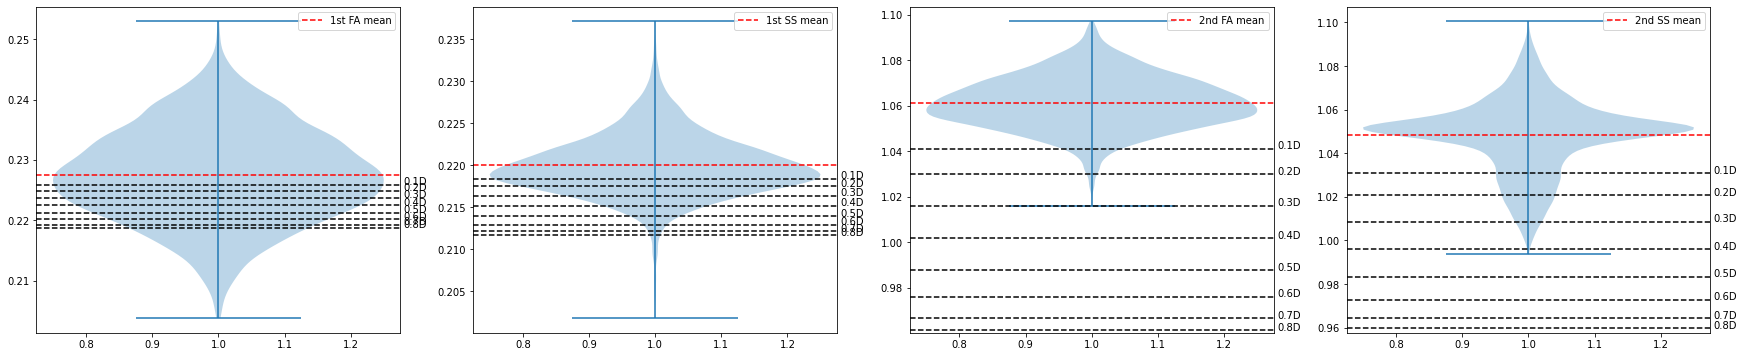

In [ ]:
modes = ['1st FA', '1st SS', '2nd FA', '2nd SS']
scours = ['0.1D', '0.2D', '0.3D', '0.4D', '0.5D', '0.6D', '0.7D', '0.8D']
average_diff_parked = get_average_diff(simulation_data, 'parked')
fig, axs = plt.subplots(1, len(modes), figsize=(30, 6))
i = 0
for mode in modes:
    data = tracked_modes[mode].loc[tracked_modes[mode].index.intersection(rated_data.index)].frequency
    axs[i].violinplot(data)
    axs[i].axhline(data.mean(), color='red', linestyle= '--', label=mode + ' mean')
    for key in average_diff_parked.keys():
        if 'LS' in key:
            axs[i].axhline(data.mean() - average_diff_parked[key][mode] * data.mean(), color='k', linestyle= '--')
            axs[i].text(1.28, data.mean() - average_diff_parked[key][mode] * data.mean(), key.split('_')[3])
    axs[i].legend()
    i += 1
plt.show()

C:\Users\Max\AppData\Local\Temp\ipykernel_18584\2576983484.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ref = simulation_data[key].mean()
C:\Users\Max\AppData\Local\Temp\ipykernel_18584\2576983484.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  average_diff[key] = (ref - simulation_data[key].mean())/ref


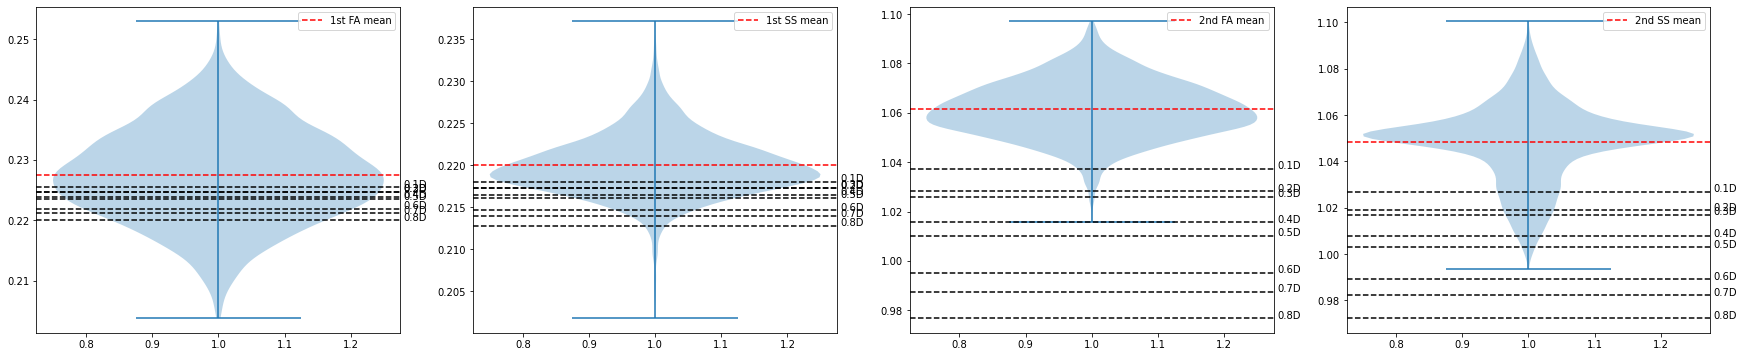

In [ ]:
modes = ['1st FA', '1st SS', '2nd FA', '2nd SS']
scours = ['0.1D', '0.2D', '0.3D', '0.4D', '0.5D', '0.6D', '0.7D', '0.8D']
average_diff_rated = get_average_diff(simulation_data, 'rated')
fig, axs = plt.subplots(1, len(modes), figsize=(30, 6))
i = 0
for mode in modes:
    data = tracked_modes[mode].loc[tracked_modes[mode].index.intersection(rated_data.index)].frequency
    axs[i].violinplot(data)
    axs[i].axhline(data.mean(), color='red', linestyle= '--', label=mode + ' mean')
    for key in average_diff_rated.keys():
        if 'LS' in key:
            axs[i].axhline(data.mean() - average_diff_rated[key][mode] * data.mean(), color='k', linestyle= '--')
            axs[i].text(1.28, data.mean() - average_diff_rated[key][mode] * data.mean(), key.split('_')[3])
    axs[i].legend()
    i += 1
plt.show()

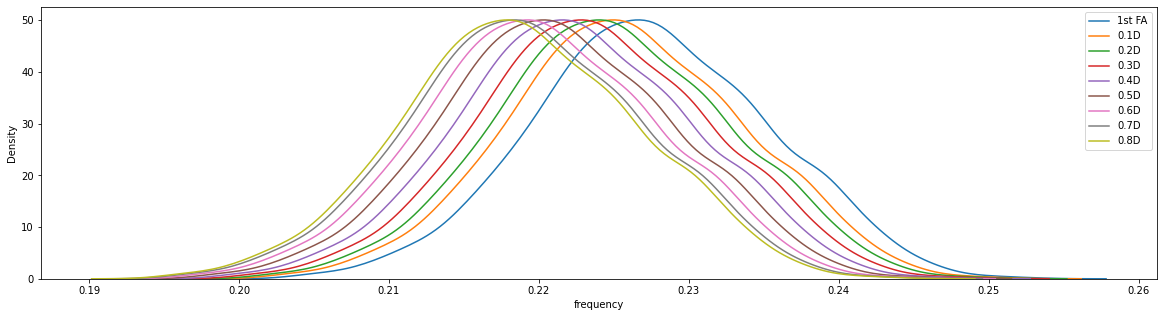

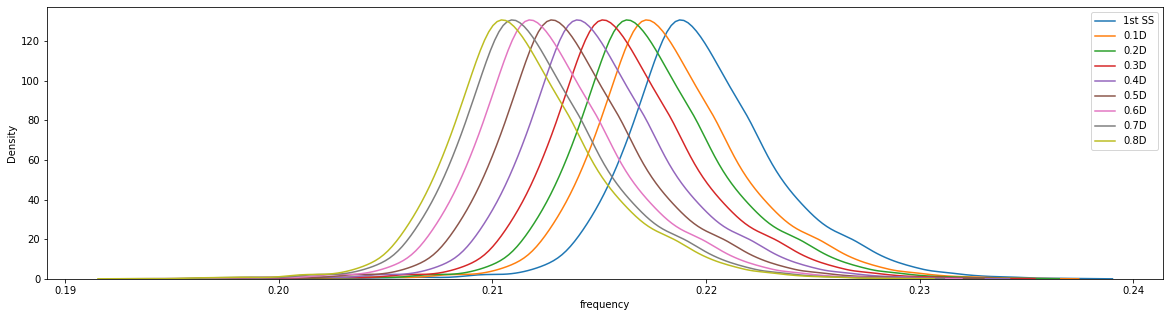

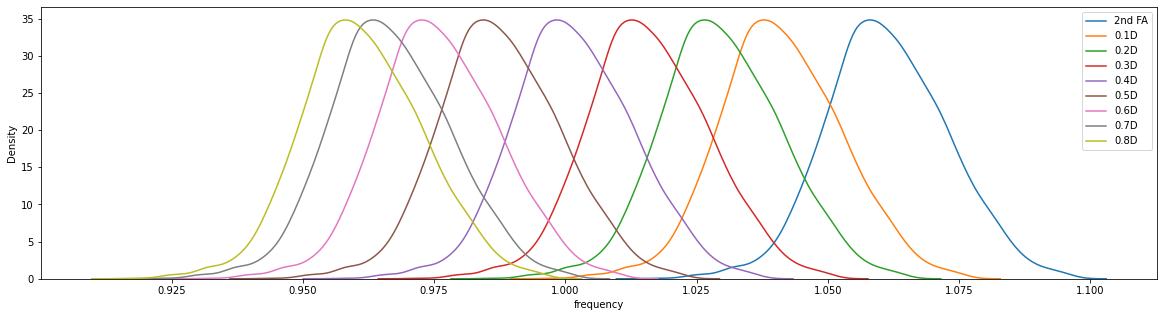

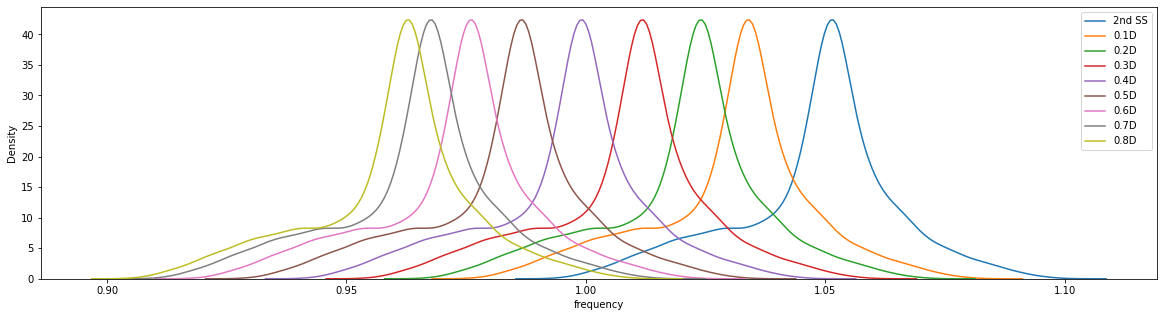

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy.stats import ks_2samp

modes = ['1st FA', '1st SS', '2nd FA', '2nd SS']
scours = ['0.1D', '0.2D', '0.3D', '0.4D', '0.5D', '0.6D', '0.7D', '0.8D']
average_diff_parked = get_average_diff(simulation_data, 'parked')
ks_statistics = pd.DataFrame(columns = modes, index = scours)
i = 0
for mode in modes:
    figure = plt.figure(figsize=(20, 5))
    data = tracked_modes[mode].loc[tracked_modes[mode].index.intersection(rated_data.index)].frequency
    sns.distplot(data, hist=False, label=mode)
    axs[i].axhline(data.mean(), color='red', linestyle= '--', label=mode + ' mean')
    ks_statistics[mode] = pd.DataFrame
    for key in average_diff_parked.keys():
        if 'LS' in key:
            sns.distplot(data - average_diff_parked[key][mode] * data.mean(), hist=False, label=key.split('_')[3])
            ks_statistic, p_value = ks_2samp(data, data - average_diff_parked[key][mode] * data.mean())
            #print(key, ', KS statistic: ', ks_statistic)
            ks_statistics[mode][key.split('_')[3]] = ks_statistic
    plt.legend()
    i += 1
    plt.show()

Text(0.5, 1.0, 'KS statistics')

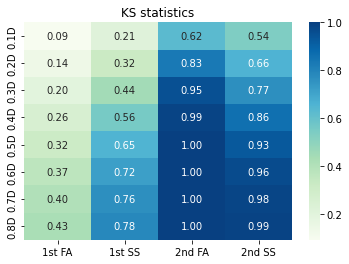

In [ ]:
import numpy as np
sns.heatmap(ks_statistics.astype(float), cmap='GnBu', annot=True, fmt='.2f')
plt.title('KS statistics')